Цели и задачи

Цель лабораторной работы: изучение принципов построения информационных систем с использованием линейных методов машинного обучения.
Основные задачи:
–	освоение методологии работы с моделями линейной регресии в задачах машинного обучения;
–	освоение метдик работы с линейными моделями в python;
–	освоение методики применения методов регрессии;
–	изучение основных параметров регрессионных моделей.
Оборудование и материалы

Для выполнения лабораторной работы рекомендуется использовать персональный компьютер со следующими программными средствами разработки (выбрать один или несколько програмных продуктов для практической реализации задач лабораторной работы): MS Visual Studio 2013 и выше; среда разработки Java, интерпретатор Python (Jupyter Notebook).

Методика и порядок выполнения работы

Постановка задачи.
В рамках учебной задачи резберем проблему «Прогноз популярности статьи на Хабре» (https://habrahabr.ru). Подробности
(https://inclass.kaggle.com/c/howpop-habrahabr-favs).
Файл howpop_test.csv содержит тестовые объекты. Файл howpop_train.csv содержит обучающую выборку. Целевая переменная – favs_lognorm. Файлы howpop_test.jsonlines и howpop_train.jsonlines содержат полные описания статей в формате JSON. Целевая переменная – favs_lognorm.
Следует обратить внимание, что howpop_train.jsonlines – файл с размером 4 ГБ.  
Переходим к решению:
17.	Подключем необходимые библиотеки:


In [ ]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

18.	Проведем первичное обследование набора данных. Выполним загрузку данных (рис. 6.2). Такое представление обучающей и тестовой выборок не дает осмысленного представления о структуре данных, вывод тяжело читается. Трансформируем вывод следующим образом (рис. 6.3): в методе head() будем выводить одну строку, а также транспонируем вывод.

In [ ]:
train_df = pd.read_csv('dataset/how pop_train.csv')
test_df = pd.read_csv('dataset/how pop_test.csv')
print('//////////////////')
print(train_df.head())
print('//////////////////')
print(test_df.head())

In [ ]:
train_df = pd.read_csv('dataset/how pop_train.csv')
test_df = pd.read_csv('dataset/how pop_test.csv')
print('|||||||||||||||||||||||||||||||||||||||||||||')
print(train_df.head(1).T)
print('|||||||||||||||||||||||||||||||||||||||||||||')
print(test_df.head(1).T)

19.	Определим размер выборок

In [ ]:
print('Тестовый набор: \t', test_df.shape)
print('Обучающая выборка: \t', train_df.shape)

20.	Получим общую информацию по фрейму:

In [ ]:
print( train_df.info ())

21.	Рассмотрим, каким образом упорядочены данные в train_df по временной оси (по published). Для этого используем код (рис. 6.7). Данные упорядочены по полю published

In [ ]:
#копируем столбец данных published
ser_data = train_df['published'].apply(lambda ts: pd.to_datetime(ts))
print('Ряд с датами столбца published')
print(ser_data.head())
print('Размер объекта Series: ', df1.shape)
ser_data.apply(lambda el: el.value).plot()

22.	Продолжим анализировать набор данных и определим, существует ли корреляция между отдельными признаками. Для этого воспользуемся методом pandas.DataFrame.corr(). Вызвав реализацию функции по умолчанию train_df.corr(), получим коэффициенты корреляции.

In [ ]:
corr = train_df.corr()
corr

По данной матрице необходимо определить коррелирующие рпизнаки (с коэффициентом корреляции больше 0.9). Искать такие значения по представленной матрице – достаточно сложная задача, которая повлечет ошибки, поэтому представим матрицу корреляции в удобном для анализа виде:

In [ ]:
corr[corr>0.9].replace({np.nan : ''})

Таким образом устанавливаем, что признаки набора данных независимы.

23.	Проведем еще одно исследование: определим как распределены публикации по годам

In [ ]:
df = train_df.copy()
df['published'] = pd.to_datetime(df['published']).dt.year
ss = df['published'].value_counts()
print(ss.sort_index())

24.	Первичное исследование набора данных завершено. Перейдем непосредственно к построению модели обучения. Разделим исходный набор данных на тренировочную и тестовую подвыборки, а также отберем признаки, которые будут использоваться в процессе обучения.

In [ ]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])
print('Размер исходного набора: ', len(train_df),
      '\nРазмер обучающей подвыборки: ', train_size)

#отделяем признаки от целевой переменной
X, y = train_df.ix[:, features], train_df['favs_lognorm']
X_test = test_df.ix[:, features]
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

25.	Для анализа контента (содержимого файлов howpop_*.jsonlines) тспользуем TfidfVectorizer из пакета sklearn. TF-IDF (от англ. TF – term frequency, IDF – inverse document frequency) – статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции.
TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.
Основные параметры TfidfVectorizer в sklearn:
–	min_df – при построении словаря слова, которые встречаются реже, чем указанное значение, игнорируются;
–	max_df – при построении словаря слова, которые встречаются чаще, чем указанное значение, игнорируются;
–	analyzer – определяет, строятся ли признаки по словам или по символам (буквам);
–	ngram_range – определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов;
–	stop_words – слова, которые игнорируются при построении матрицы.
Создадим объект TfidfVectorizer и обучим его на данных


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))
vX_train_title = vectorizer_title.fit(X_train['title'])
print('vX_train_title.vocabulary_:', len(vX_train_title.vocabulary_))
vX_valid_title = vectorizer_title.fit(X_valid['title'])
print('vX_train_title.vocabulary_:', len(vX_train_title.vocabulary_))
vX_test_title = vectorizer_title.fit(X_test['title'])

print('vX_train_title.vocabulary_:', len(vX_train_title.vocabulary_))
X_train_title = vectorizer_title.fit_transform(X_train['title'])
print('X_train_title.shape: ', X_train_title.shape)
X_valid_title = vectorizer_title.transform(X_valid['title'])
print('X_valid_title.shape: ', X_valid_title.shape)
X_test_title = vectorizer_title.transform(X_test['title'])
print('X_test_title.shape: ', X_test_title.shape)

Получили три словаря и три матрицы TF-IDF. Для доступа к словарям можно обратиться к полю vocabulary_ объекта TfidfVectorizer. К этому времени объект должен быть обучен – должен быть вызван метод
fit_transform().


In [ ]:
X_test_title.vocabulary_

Данные в словаре хранятся в формате {'термин': индекс признака,...}.

26.	Построим TF-IDF-матрицы для этих же признаков, но с использованием параметра analyzer='char'

In [ ]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

vX_train_title_ch = vectorizer_title_ch.fit(X_train['title'])
print('vX_train_title_ch.vocabulary_:', len(vX_train_title_ch.vocabulary_))
vX_valid_title_ch = vectorizer_title_ch.fit(X_valid['title'])
print('vX_valid_title_ch.vocabulary_: ', len(vX_valid_title_ch.vocabulary_))
vX_test_title_ch = vectorizer_title_ch.fit(X_test['title'])
print('vX_test_title_ch.vocabulary_:', len(vX_test_title_ch.vocabulary_))

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
print('X_train_title_ch.shape: ', X_train_title_ch.shape)
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
print('X_valid_title_ch.shape: ', X_valid_title_ch.shape)
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])
print('X_test_title_ch.shape: ', X_test_title_ch.shape)

27.	Для 	обработки 	остальных 	признаков 	будем 	использовать DictVectorizer из sklearn. Признаки ['author', 'flow', 'domain'] имеют категориальную природу, для них TfidfVectorizer неприменим.

In [ ]:
vectorizer_feats = DictVectorizer()
tmp_dict_train = X_train[feats].fillna('-').T.to_dict().values()
tmp_dict_valid = X_valid[feats].fillna('-').T.to_dict().values()
tmp_dict_test = X_test[feats].fillna('-').T.to_dict().values()

X_train_feats = vectorizer_feats.fit_transform(tmp_dict_train)
X_valid_feats = vectorizer_feats.transform(tmp_dict_valid)
X_test_feats = vectorizer_feats.transform(tmp_dict_test)
print(X_train_feats.shape)
print(X_valid_feats.shape)
print(X_test_feats.shape)

28.	Выполним объединение полученных матриц

In [ ]:
#объединение матриц, построенных на предыдущих этапах
X_train_new = scipy.sparse.hstack([X_train_title,
                                  X_train_feats,
                                  X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title,
                                  X_valid_feats,
                                  X_valid_title_ch])
X_test_new = scipy.sparse.hstack([X_test_title,
                                  X_test_feats,
                                  X_test_title_ch])
print(X_train_new.shape)
print(X_valid_new.shape)
print(X_test_new.shape)

Следует обратить внимание, что операция объединения допустима над полученными матрицами (поясните почему).

29.	Для обучения выбрана линейная модель регрессии с L2регуляризацией

In [ ]:
%%time
model_1 = Ridge(alpha=.1, random_state=1)
model_1.fit(X_train_new, y_train)

In [ ]:
train_press1 = model_1.predict(X_train_new)
valid_predc1 = model_1.product(X_valid_new)
print('Ошибка на трейне: ', mean_squared_error(y_train, train_press1))
print('Ошибка на тесте: ', mean_squared_error(y_valid, valid_predc1))

30.	Выполним обучение еще одной модели и проверим ошибки

In [ ]:
%%time
model_2 = Ridge(alpha=1.0, random_state=1)
model_2.fit(X_train_new, y_train)

In [ ]:
train_preds2 = model_2.predict(X_train_new)
valid_preds2 = model_2.predict(X_valid_new)
print('Ошибка на трейне:', mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте:', mean_squared_error(y_valid, valid_preds2))

Важные замечания
1.	При выборе набора данных (data set) на ресурсах [3, 4] необходимо согласовать свой выбор с другими студентами группы и преподавателем с целью недопустимости выбора одинаковых вариантов.
2.	В рамках данного лабораторного курса рекомендуется использовать инструментарий Python (библиотеки, среду разработки) для решения поставленных задач.

Индивидуальное задание
1.	Студент самостоятельно выбирает набор данных на ресурсах [3, 4] для построения классификатора с использованием метода логической классификации и согласует свой выбор с преподавателем.
2.	Выполните построение модели классификации на основе дерева классификации. В ходе решения задачи необходимо решить следующие подзадачи:
2.1	Построение логического классификатора с заданием max_depth (максимальной глубины) и max_features (максимального количества признаков) пользователем (установить любые); визуализация дерева решений для выбранных исследователем параметров (в формате .png)
2.2	Вычисление оценки cross validation (MSE) для различнх значений max_depth (построить график зависимости);
2.3	Вычисление оценки cross validation (MSE) для различнх значений max_features (построить график зависимости);
2.4	Вычислите оптимальные значения max_depth и max_features. Обоснуйте свой выбор. Продемонстрируйте использование полученного классификатора.  
2.5	Выведите дерево в формате .png;
2.6	Выведите решающие границы полученной модели.

Содержание отчета и его форма

Отчет по лабораторной работе должен содержать:
1.	Номер и название лабораторной работы; задачи лабораторной работы.
2.	Реализация каждого пункта подраздела «Индивидуальное задание» с приведением исходного кода программы, диаграмм и графиков для визуализации данных.
3.	Ответы на контрольные вопросы.
4.	Экранные формы (консольный вывод) и листинг программного кода с комментариями, показывающие порядок выполнения лабораторной работы, и результаты, полученные в ходе её выполнения.
Отчет о выполнении лабораторной работы сдается преподавателю.

Контрольные вопросы

1.	Какие методы классификации являются линейными?
2.	Укажите основные параметры линеймой модели классификации.
3.	Поясните назначение и принципы реализации методов стахостического градиента.
4.	В чем заключается главная идея метода опорных векторов?
5.	Что такое «линейно разделимая выборка»?
6.	Поясните назначение ядер и спрямляющих пространств в алгоритмах линейной классификации.

Список литературы

Для выполнения лабораторной работы, при подготовке к защите, а также для
ответа на контрольные вопросы рекомендуется использовать следующие источники: [1–5].


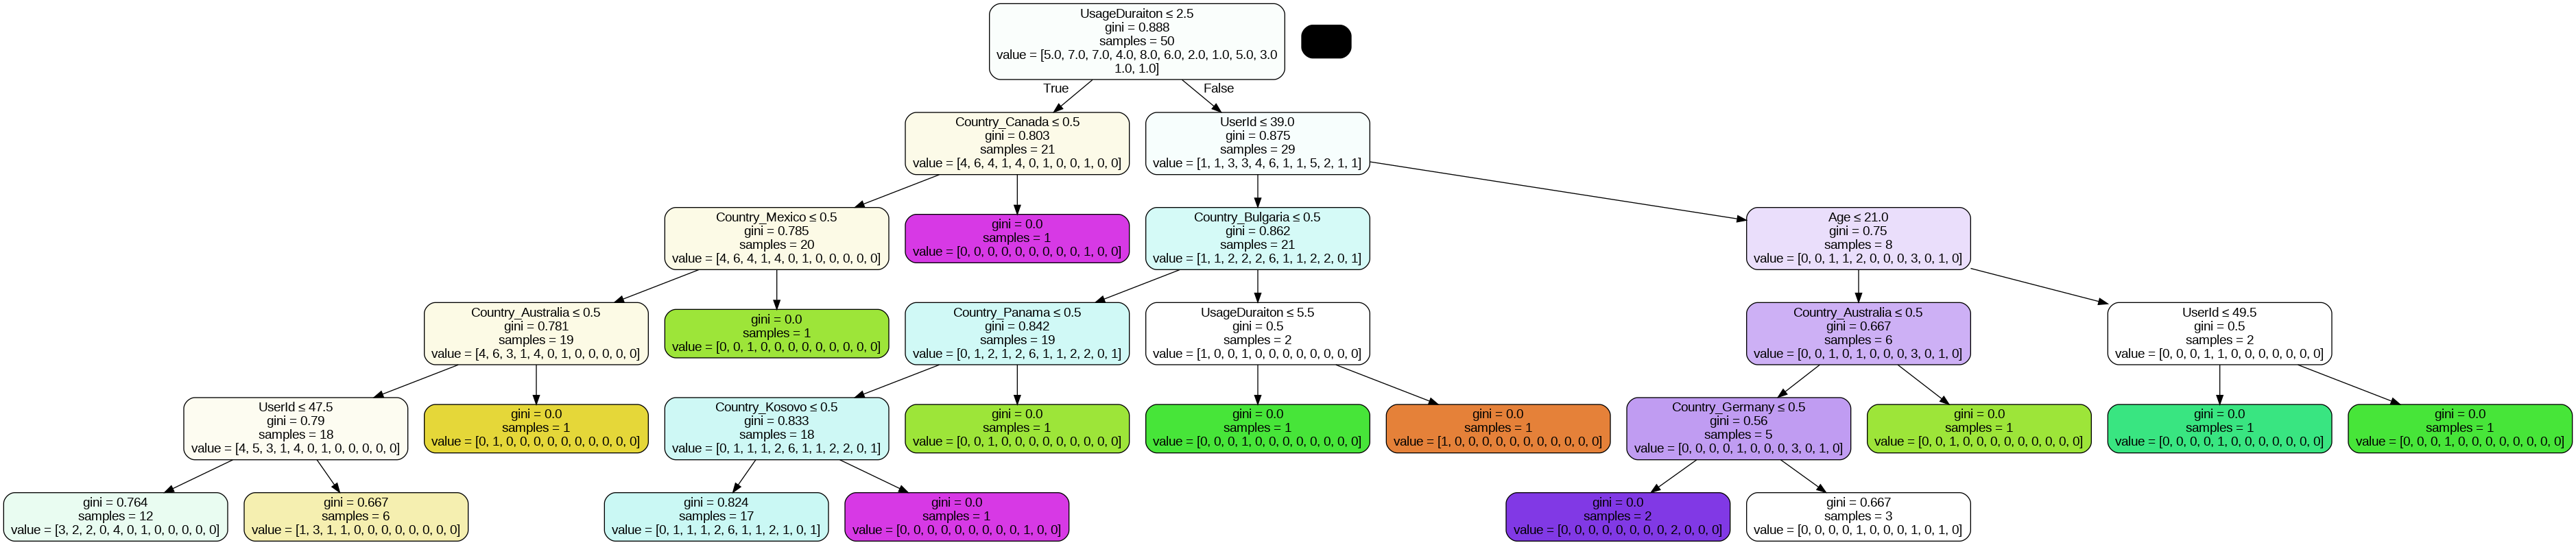

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image

# Загрузка данных
data = pd.read_csv('social-media.csv')

# Предобработка данных
# Предположим, что Country является категориальным признаком, который нужно закодировать
data = pd.get_dummies(data, columns=['Country'])

# Разделение на признаки и целевую переменную
X = data.drop('TotalLikes', axis=1)
y = data['TotalLikes']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели
model = DecisionTreeClassifier(max_depth=5, max_features=3, random_state=42)
model.fit(X_train, y_train)

# Визуализация дерева решений
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)

# Создание графа с использованием pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

# Сохранение графа в файл .png
graph.write_png("decision_tree.png")

# Отображение изображения в Jupyter Notebook
Image(filename='decision_tree.png')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

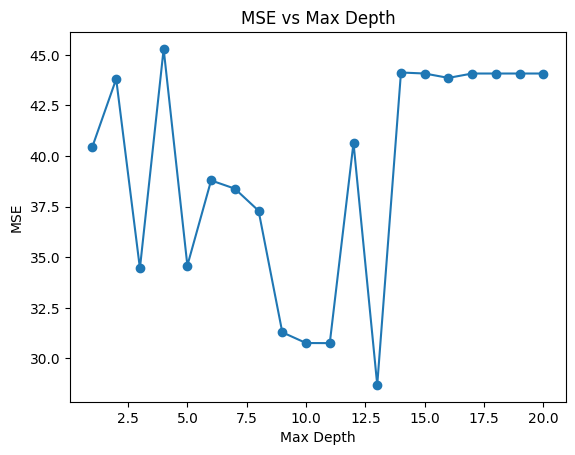

In [21]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

depths = range(1, 21)
mse_scores_depth = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, max_features=3, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores_depth.append(-scores.mean())

# Построение графика
plt.plot(depths, mse_scores_depth, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('MSE vs Max Depth')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

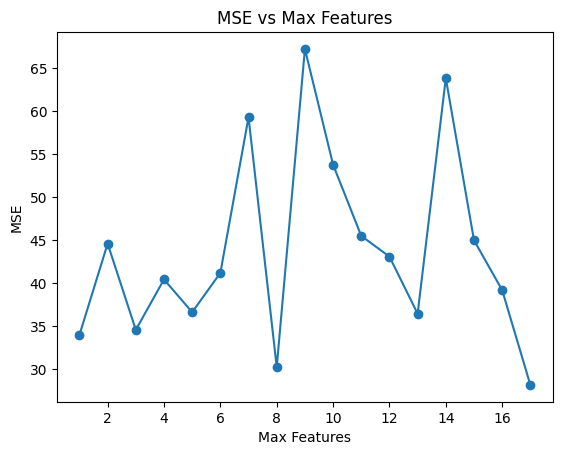

In [22]:
features = range(1, len(X.columns) + 1)
mse_scores_features = []

for feature in features:
    model = DecisionTreeClassifier(max_depth=5, max_features=feature, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores_features.append(-scores.mean())

# Построение графика
plt.plot(features, mse_scores_features, marker='o')
plt.xlabel('Max Features')
plt.ylabel('MSE')
plt.title('MSE vs Max Features')
plt.show()


Оптимальное значение max_depth: 13
Оптимальное значение max_features: 17


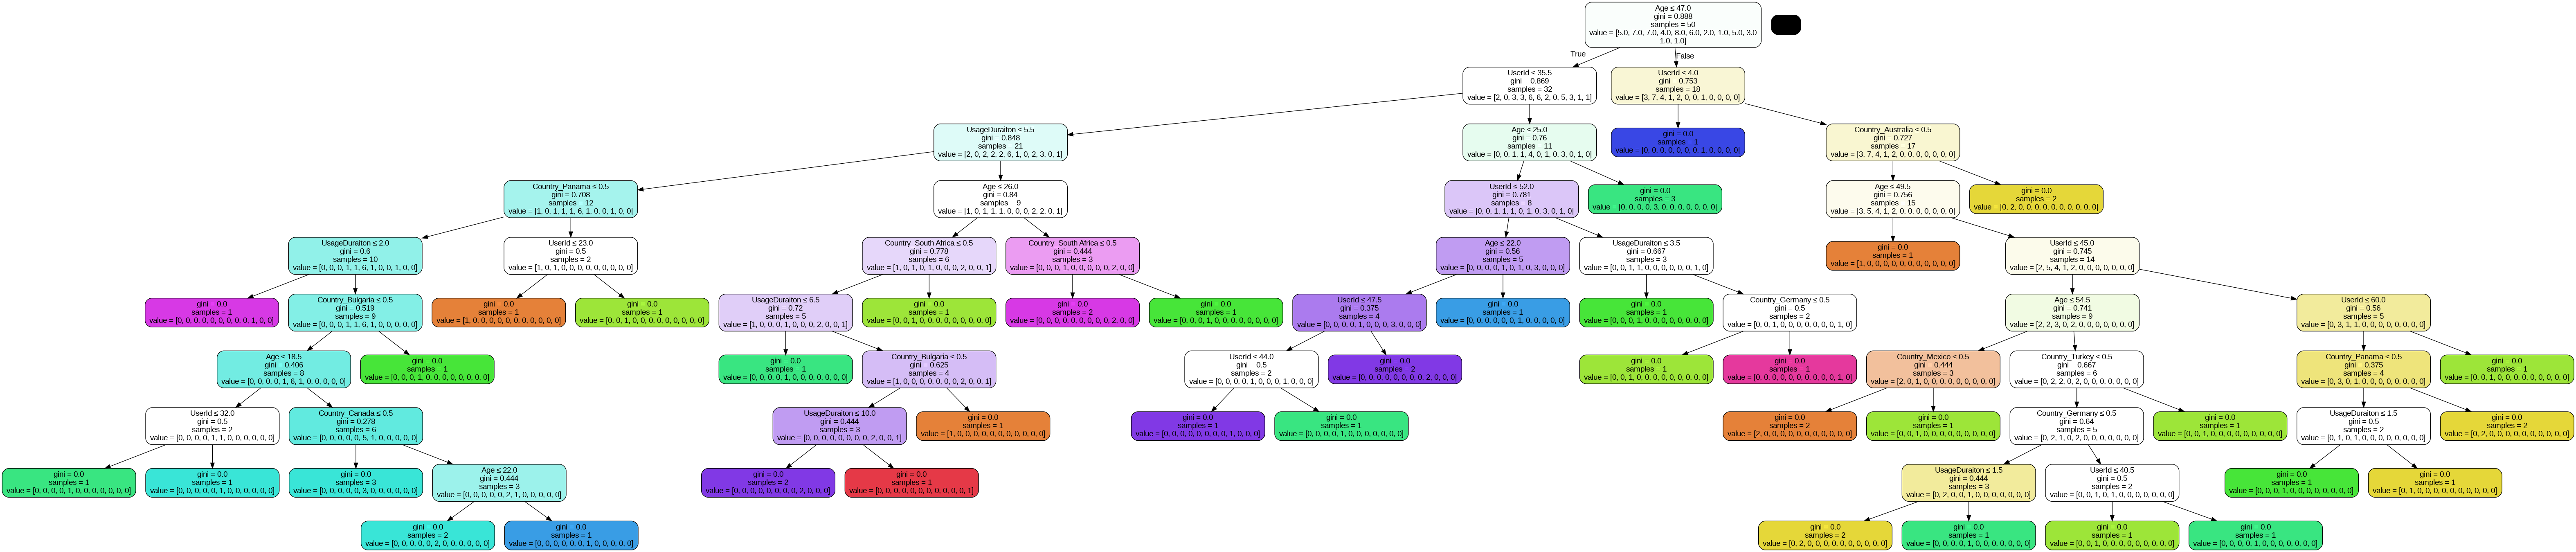

In [25]:
# Нахождение оптимальных параметров
best_depth = depths[mse_scores_depth.index(min(mse_scores_depth))]
best_features = features[mse_scores_features.index(min(mse_scores_features))]

print(f"Оптимальное значение max_depth: {best_depth}")
print(f"Оптимальное значение max_features: {best_features}")

# Построение модели с оптимальными параметрами
best_model = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features, random_state=42)
best_model.fit(X_train, y_train)

# Визуализация дерева решений
dot_data = export_graphviz(best_model, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)

# Создание графа с использованием pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

# Сохранение графа в файл .png
graph.write_png("best_decision_tree.png")

# Отображение изображения в Jupyter Notebook
Image(filename='best_decision_tree.png')


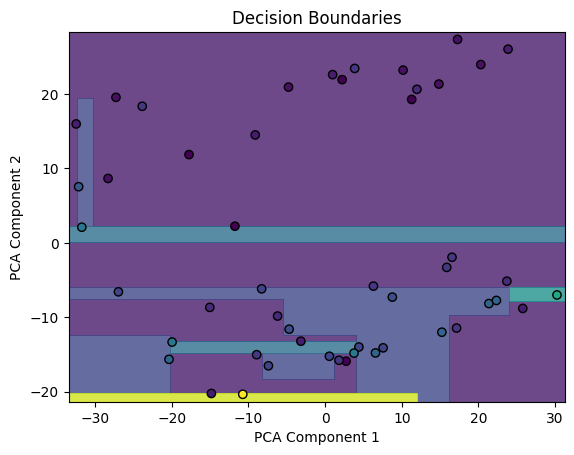

In [26]:
from sklearn.decomposition import PCA
import numpy as np

# Уменьшение размерности до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Построение модели
best_model_pca = DecisionTreeClassifier(max_depth=best_depth, max_features=2, random_state=42)
best_model_pca.fit(X_train_pca, y_train)

# Визуализация решающих границ
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = best_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundaries')
plt.show()
